In [1]:
import cv2
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from deskew import determine_skew
import face_recognition
import time
import keras
import pickle
import shutil
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from easyocr import Reader
from difflib import SequenceMatcher
readerLatin = Reader(["en"], gpu=True)
readerArabic = Reader(["ar"], gpu=True)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
relative_path = "../Docs/dataset"
passport_list = os.listdir(relative_path)
passport_list = [p for p in passport_list if p[-4:]==".jpg" or p[-4:]==".png"]

In [3]:
bar_classifier = keras.models.load_model('assets/models/bar_classifier')
script_classifier = keras.models.load_model('assets/models/script classifierv1')

In [4]:
svm_bar_classifier = pickle.load(open("assets/models/svm_bar_classifier", 'rb'))

In [5]:
east_path = os.path.join("assets\models","frozen_east_text_detection.pb")
print(east_path)
min_confidence = 0.9
net = cv2.dnn.readNet(east_path)

assets\models\frozen_east_text_detection.pb


In [6]:
def face_detect_rotate(image):
    trials = 0
    while(trials<4):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face_locations = face_recognition.face_locations(gray)
        if(len(face_locations)>0):
            main_face = max(face_locations,key = lambda x : abs(x[0] - x[2]) * abs(x[1] - x[3]))
            right= main_face[1]
            bottom = main_face[2]
            return (right,bottom,image)
        else : 
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) 
            trials += 1
    return 0
def traditional_processing(image,kw,kh):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kw, kh))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    gray = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(gray)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)
    return thresh

def show(image):
    fig = plt.figure(figsize=(10, 10))
    rows = 1
    columns = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(image)
    plt.title("image")
    plt.axis('off')
def show2(im1,im2):
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(im1)
    plt.title("image1")
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(im2)
    plt.title("image1")
    plt.axis('off')
def drawROIs(image,boxes):
    im = image.copy()
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,0,0),2)
    return im

def top_slash_coordinates(image,boxes):
    boxes = sorted(boxes,key=lambda x : x[1])
    message = "REPUBLIC OF TUNISIA"
    for box in boxes:
        (startX, startY, endX, endY) = box
        clip = image[startY:endY,startX:endX]
        results = readerLatin.readtext(clip)
        texts = [res[1] for res in results]
        text="".join(texts)
        if SequenceMatcher(None, text, message).ratio()>0.5:
            return endY
    return 0
def decode_predictions(scores, geometry,min_confidence):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue
            
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    return (rects, confidences)
def model_based_ROI_extraction(image):
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    (height , width) = image.shape[:2]
    ratio = width / height
    nh = 1024
    while(height>nh):
        nh = nh + 1024
    nw = int(nh * ratio)
    nw = nh - nh%32
    image = cv2.resize(image, (nw,nh), interpolation = cv2.INTER_AREA)
    blob = cv2.dnn.blobFromImage(image, 1.0, (nw, nh),(128, 128, 128), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    (rects, confidences) = decode_predictions(scores, geometry,min_confidence)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    return image,boxes
def increase_contrast(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl,a,b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

In [7]:
def extract_bar(image,kw,kh,delim,left):
    original = image.copy()
    image = traditional_processing(image,kw,kh)
    im_h,im_w = image.shape[:2]
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = [cv2.boundingRect(c) for c in cnts]
    cnts = [(x,y,x+w,y+h) for (x, y, w, h) in cnts]
    bar_position = [x for x in cnts if x[3] >delim and left<x[0]]
    cnts = sorted(cnts,key = lambda x : x[1])
    for c in bar_position:
        (xstart,ystart,xend,yend)= c
        clip = original[ystart:yend,xstart:xend]
        results = readerLatin.readtext(clip)
        texts = [res[1] for res in results]
        text=" ".join(texts)
        if text == "":
            clip = cv2.resize(clip, (300,70), interpolation = cv2.INTER_AREA)
            clip = clip.flatten()
            probs = svm_bar_classifier.predict_proba([clip])
            if probs[0][0]>probs[0][1]+0.5:
                break
    top = top_slash_coordinates(original,cnts)
    return (xstart,ystart,top)

In [8]:
def rotateImage(cvImage, angle):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [9]:
def deskewing(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    return rotateImage(image, -1.0 * angle)

In [10]:
def fetch_text(image,cnts):
    boxes = []
    kernel = np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])
    for c in cnts:
        (xstart,ystart,xend,yend)= c
        clip = image[ystart:yend,xstart:xend]
        clip = cv2.filter2D(src=clip, ddepth=-1, kernel=kernel)
        #predict script
        clip = cv2.resize(clip, (300,70), interpolation = cv2.INTER_AREA)
        clip = np.reshape(clip,(1,300,70,3))
        prob = script_classifier.predict(clip,verbose=0)
        """
        results = readerLatin.readtext(clip)
        results = results + readerArabic.readtext(clip)
        texts = [res[1] for res in results]
        text = "".join(texts)
        """
        #append if script
        if prob[0] > 0.2 : #len(text)>1 and "<" not in text:
            boxes.append(c)
    return boxes

In [11]:
def boundary_check(original,cnts):
    kernel = np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])
    text = ""
    while(text==""):
        (xstart,ystart,xend,yend) = cnts[0]
        clip = original[ystart:yend,xstart:xend]
        clip = cv2.filter2D(src=clip, ddepth=-1, kernel=kernel)
        results = readerLatin.readtext(clip)
        results = results + readerArabic.readtext(clip)
        texts = [res[1] for res in results]
        text = "".join(texts)
        if text == "" or "<" in text:
            cnts.remove(cnts[0])
    return cnts

In [14]:
def adjust(image):
    kernel = np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    original = image.copy()
    
    image = traditional_processing(image,40,8)
    cnts = cv2.findContours(image, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = [cv2.boundingRect(c) for c in cnts]
    cnts = [(x,y,x+w,y+h) for (x, y, w, h) in cnts if w*h > 50*10*4 and w>h]
    
    #cnts = fetch_text(original,cnts)
    cnts = sorted(cnts , key = lambda x : x[0])
    cnts = boundary_check(original,cnts)
    
    cnts = sorted(cnts , key = lambda x : x[3],reverse = True)
    cnts = boundary_check(original,cnts)
    
    (h,w) = image.shape[:2]
    buffer = 10
    top = max([min(cnts , key = lambda x : x[1])[1]-buffer,0])
    bottom = min([max(cnts , key = lambda x : x[3])[3]+buffer,h])
    right = min([max(cnts , key = lambda x : x[2])[2]+buffer,w])
    left = max([min(cnts , key = lambda x : x[0])[0]-buffer,0])
    
    final = original[top:bottom,left:right]
    enhanced = increase_contrast(final)
    return final

both svm and cnn have a processing time of about 0.04 per example but whilst cnn has an accuaracy on testing dataset of 87% svm has an accuracy of 92% as a result the choice is going to be svm 

7 %==>15 %==>23 %==>30 %==>38 %==>46 %==>53 %==>61 %==>69 %==>76 %==>84 %==>92 %==>100 %==>average cropping time :  7.037448442899263


NameError: name 'j' is not defined

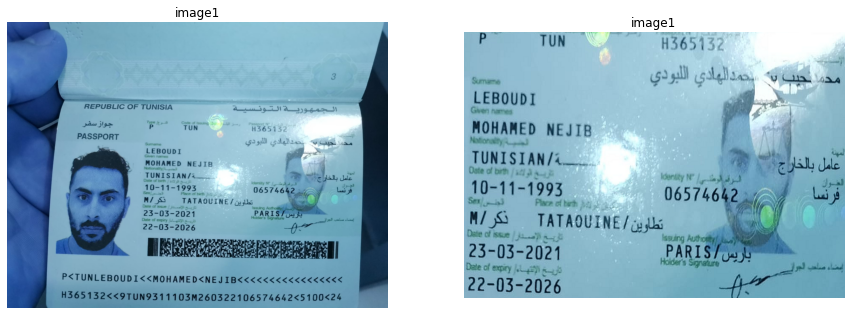

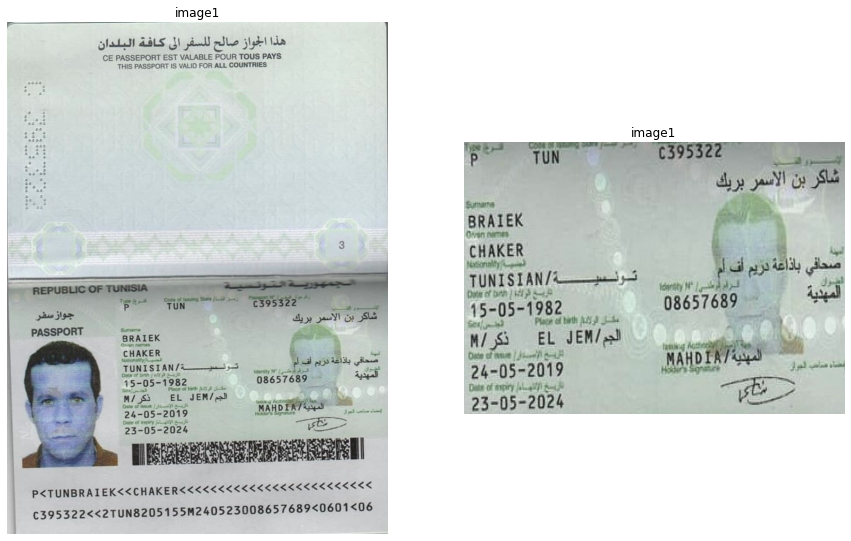

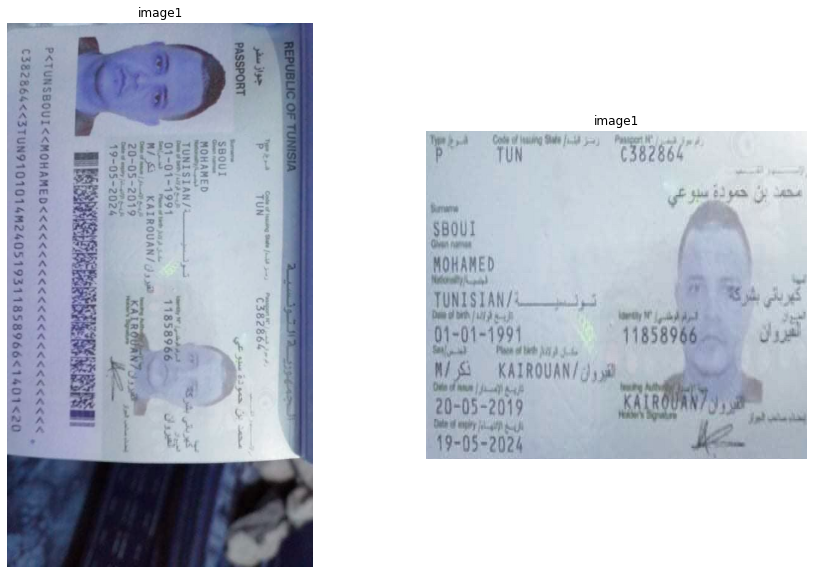

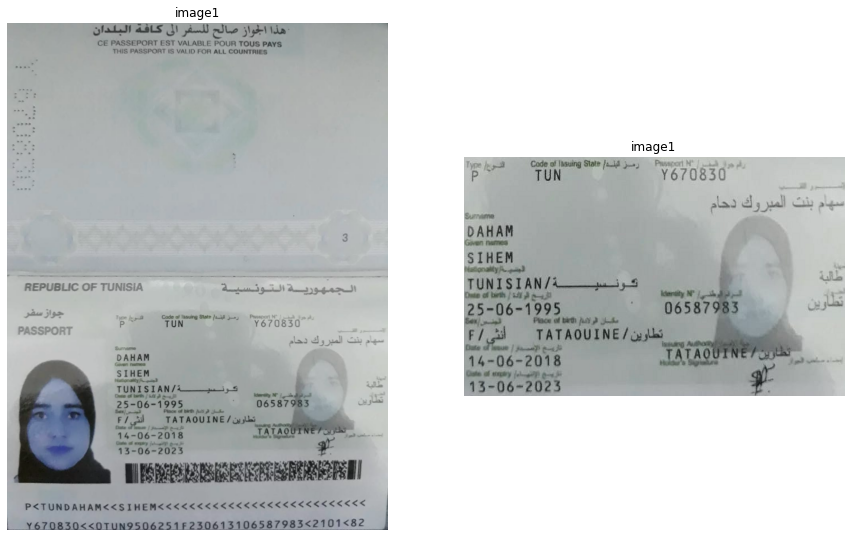

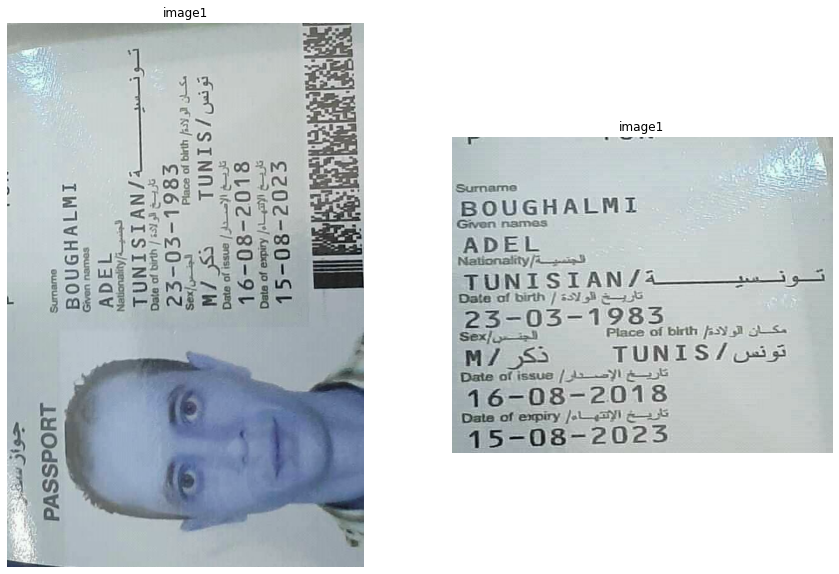

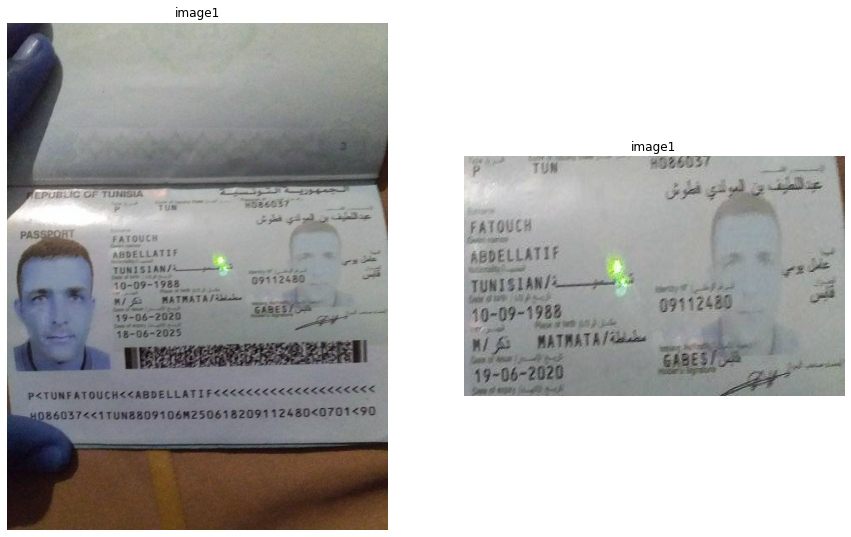

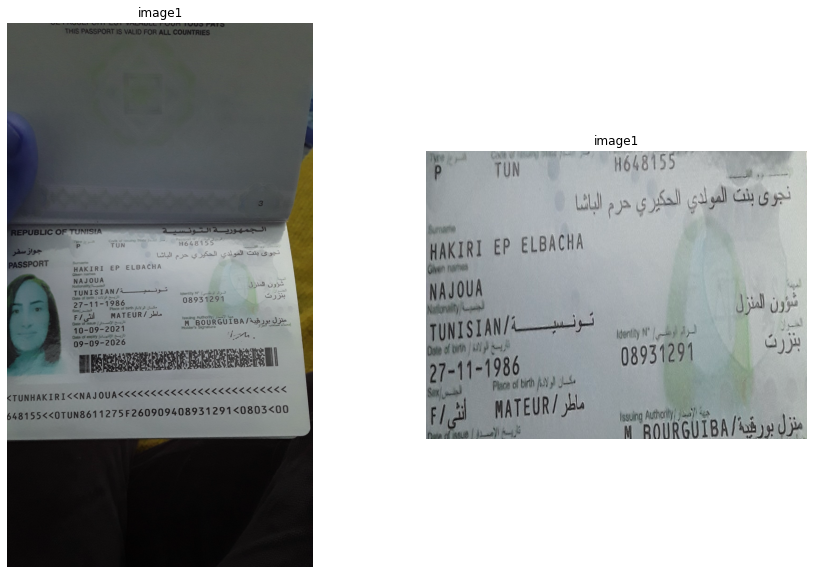

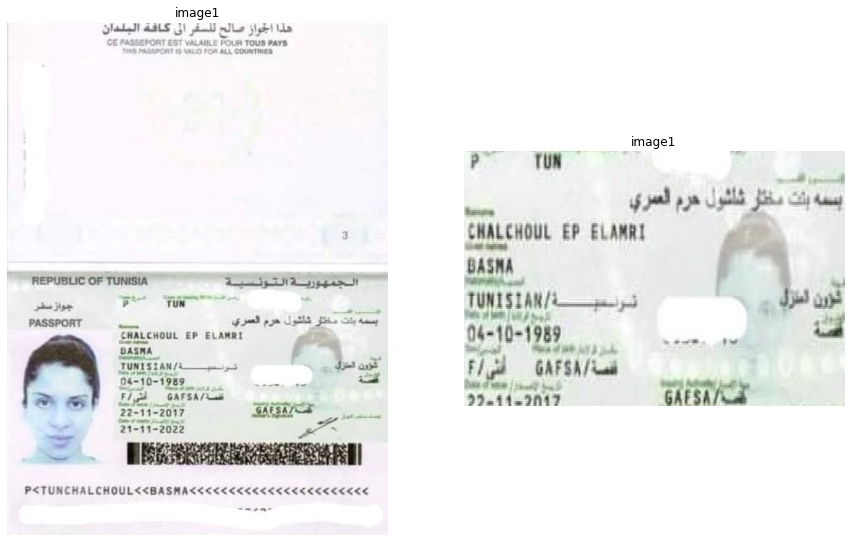

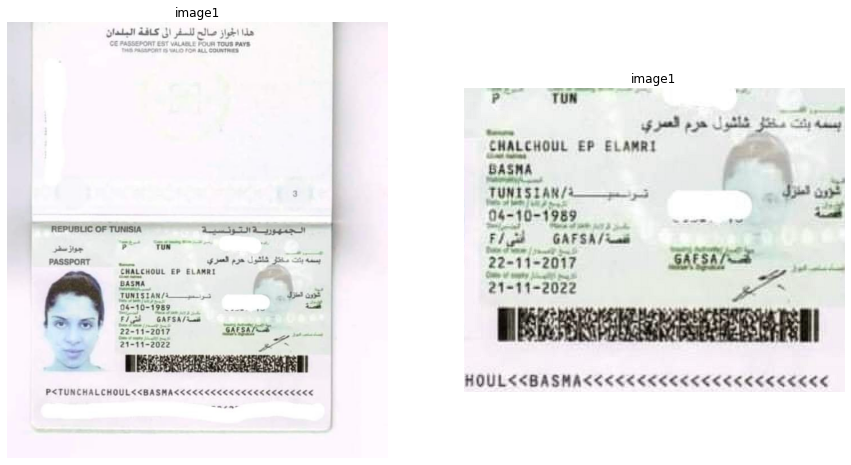

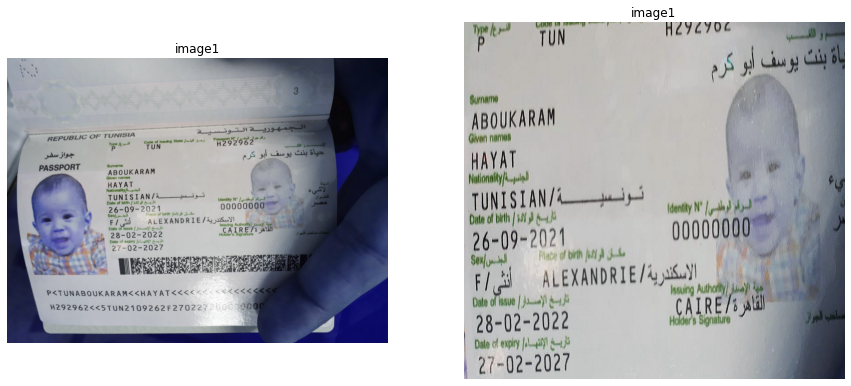

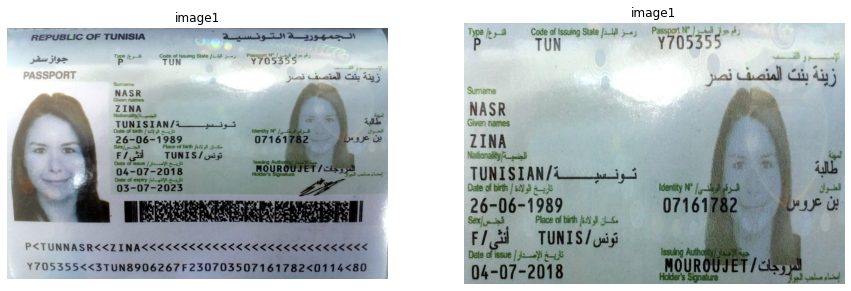

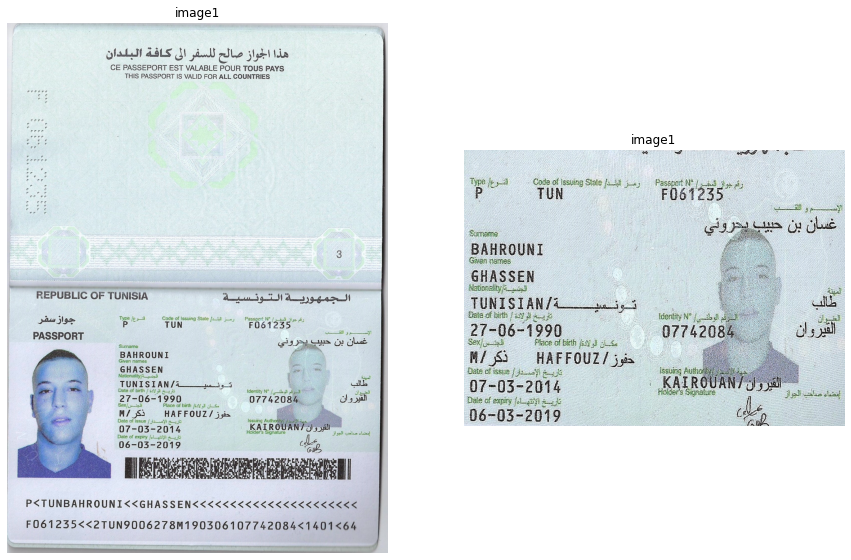

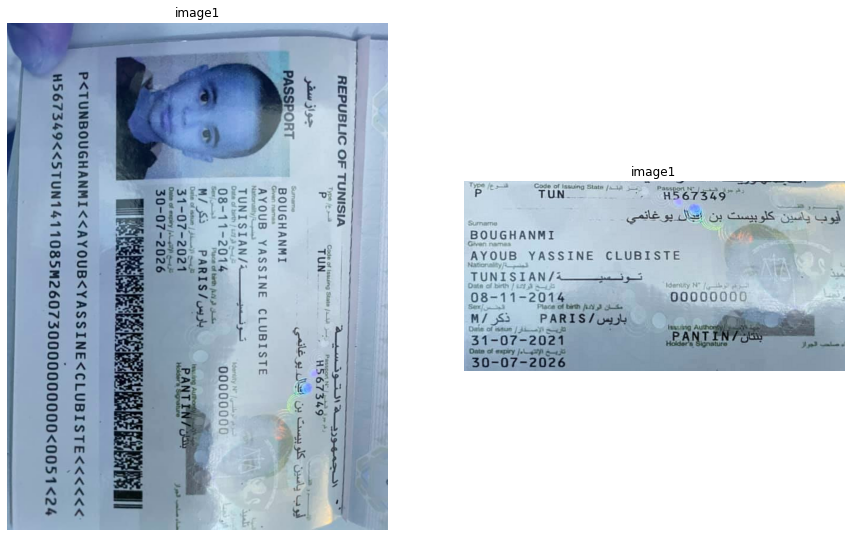

In [15]:
s = 0
for i in passport_list:
    start = time.time()
    im_path = os.path.join(relative_path,i)
    im = cv2.imread(im_path)
    original = im.copy()
    try :
            left,bottom,im=face_detect_rotate(im)
            try : 
                (barX,barY,top) = extract_bar(im,40,8,bottom,left)
                #set a bottom and left check for the date
                im = im[top:barY,left:]
                (h,w) = im.shape[:2]
                if (h*w < 1024*1024):
                    im = cv2.resize(im,(1500,1000),interpolation = cv2.INTER_AREA)
                im = adjust(im)
            except Exception as e :
                print(e)
    except Exception as e:
        print(e)
    end = time.time()
    s = s + end-start
    print(int((passport_list.index(i)+1)/len(passport_list)*100),"%",end="==>")
    show2(original,im)
    break
print("average cropping time : ", s / len(passport_list))
j = j +1

In [ ]:
methods = ["cnn","svm"]
for method in methods:
    sum_time = 0
    for i in passport_list:
        im_path = os.path.join(relative_path,i)
        im = cv2.imread(im_path)
        (h,w) = im.shape[:2]
        try : 
            _,im=face_detect_rotate(im) 
            try : 
                start = time.time()
                (xstart,ystart,xend,yend) = extract_bar(im,35,7,"svm")
                end = time.time() - start
                sum_time = sum_time +end
            except Exception as e :
                print("skiping no code bar ")
        except Exception as e:
            print("skiping no face")
    sum_time = sum_time / len(passport_list)
    print("time for method "+method+" : ",sum_time)

In [123]:
for i in passport_list:
    im_path = os.path.join(relative_path,i)
    shutil.move(os.path.join(relative_path+"/bad quality",i) , im_path)